# <span style="color:#F72585"><center>Transformers - Código TF2</center></span>

<center>Transformers</center>

<figure>
<center>
<img src="../Imagenes/toy_transformer.jpg" width="700" height="700" align="center"/>
</center>
</figure>


Fuente: [Pixabay](https://pixabay.com/es/photos/peque%c3%b1o-juguete-figurilla-3871893/)

## <span style="color:#4361EE">Introducción</span>

En esta lección construimos el modelo Transformer pieza por pieza. Cada pieza es probada individualmente. La implementación está hecha en *TensorFlow 2.X.* La imagen muestra la arquitectura completa del transformer, como la presentaron sus autores en el artículo [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf).

<figure>
<center>
<img src="../Imagenes/Transformer_original.png" width="400" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Transformer</p>
</figcaption>
</figure>

Fuente: [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf)

## <span style="color:#4361EE">Codificación posicional</span>

Con el propósito de incluir una pieza de información en el modelo relacionada con la posición de las palabras en cada sentencia (oración) los autores del Transformer [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf) introdujeron la codificación posicional que tiene las siguientes características:

* Genera una codificación única para cada paso de tiempo (la posición de la palabra en una oración).
* La distancia entre dos pasos de tiempo debe ser coherente en las oraciones de diferente longitud.
* La generalización a oraciones más largas se puede hacer sin ningún esfuerzo. Sus valores deben ser acotados.
* Es determínista.

La codificación de cada palabra en una oración es un vector $d$-dimensional, en donde $d$ es la dimensión del embedding (inscrustación), que contiene información sobre una posición específica en una oración. Esta codificación no está integrada en el modelo en sí. En cambio, este vector se usa para equipar cada palabra con información sobre su posición en una oración. En otras palabras, mejoramos la entrada del modelo para inyectar el orden de las palabras.

Supongamos que $t$ es la  posición deseada en una oración de entrada y que $p_t \in \mathbb{R}^d$ es su correspondiente codificación. Entonces la función codificadora $f:\mathbb{N}\to \mathbb{R}^d$ es definida componente a componente mediante

$$
p_t^{(i)} = f(t)^{(i)} = \begin{cases}
sin(w_k\cdot t) & \text{si i = 2k}\\
cos(w_k\cdot t) & \text{si i = 2k+1},
\end{cases}
$$
en donde

$$
w_k = \frac{1}{10000^{2k/d}}
$$


Se puede derivar de la definición de la función, que las frecuencias están disminuyendo a lo largo de la dimensión vectorial $d$. Por lo tanto, forma una progresión geométrica de $2\pi$ a $10000 \cdot 2\pi$  en las longitudes de onda.

También puedes imaginar la incrustación posicional $p_t$  como un vector que contiene pares de senos y cosenos para cada frecuencia tenga en cuenta que $d$  es divisible por 2:

$$
\begin{align}
p_t = \begin{pmatrix} 
sin(w_1t)\\
cos(w_1t)\\
\cdots\\
sin(w_{d/2}t)\\
cos(w_{d/2}t)\\
\end{pmatrix}
\end{align}_{d \times 1}
$$

Para tener una intuición de la codificación, recordemos como ocurre la codificación posicional de los números enteros en binario, usando 4 dígitos binarios:

* 0: 0000 
* 1: 0001
* 2: 0010
* 3: 0011
* 4: 0100
* 5: 0101
* 6: 0110
* 7: 0111
* 8: 1000
* 9: 1001
* 10: 1010
* 11: 1011
* 12: 1100
* 13: 1101
* 14: 1110
* 15: 1111

Observe como el primer dígito a la izquierda cambia muy despacio. Realmente toma dos valores 0 para las primeras 8 posiciones y 1 en las últimas ocho. En contraste el bit menos significativo (el de más a la derecha) cambia en cada paso.

La función $f(t)$ puede considerarse como una versión contínua de este esquema de codificación binaria. 

De acuerdo con los autores del Transformer ellos eligieron esta función porque "planteamos la hipótesis de que permitiría al modelo aprender fácilmente a atender por posiciones relativas, ya que para cualquier desplazamiento fijo $k$", $f(t+k)$ "se puede representar como una función lineal de" $f(t)$. Realmente puede demostrarse que existe una transformación lineal $M$ tal que para cualquier $\phi$ independientemente de $t$ se tiene que

$$
M \cdot\begin{pmatrix}
sin( w_k\cdot t)\\
cos( w_k\cdot t)
\end{pmatrix} = \begin{pmatrix}
sin( w_k\cdot (t+\phi))\\
cos( w_k\cdot (t+\phi))
\end{pmatrix}.
$$

Para los detalles y una demostración consulte [Transformer Architecture: The positional encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

El vector de codificación posicional se agrega al vector de incrustación. Las incrustaciones representan un token en un espacio $d$-dimensional donde los tokens con un significado similar estarán más cerca unos de otros. Pero las incrustaciones no codifican la posición relativa de las palabras en una oración. Así que después de la adición de la codificación posicional, palabras estarán más cerca el uno al otro sobre la base de la similitud de su significado y de su posición en la oración, en el espacio $d$-dimensional.

Pasemos a la implementación con tensorflow.

In [2]:
import tensorflow as tf

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    '''Codificador possicional.
       position: máxima longitud de una sentencia
       d_model: tamaño del embedding(incrustación)
    '''
    def __init__(self, position=2048, d_model=512):
        super(PositionalEncoding, self ).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1/tf.pow(10000, (2 * (i // 2)) /tf.cast(d_model, tf.float32))
        return position * angles 
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:,tf.newaxis],
            i = tf.range(d_model, dtype= tf.float32)[tf.newaxis,:],
            d_model = d_model).numpy() # shape=(position, d_model)
        # aplica sin a los índices pares del arreglo
        angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])
        # aplica cos al índices impares del arreglo
        angle_rads[:, 1::2] = np.cos(angle_rads[:,1::2])     
        # agrega un eje al comienzo del array
        pos_encoding = angle_rads[tf.newaxis, ...] # shape =(1, position, d_model)
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
        
    

### <span style="color:#4CC9F0">Test de la clase PositionalEncoding</span>

(1, 2048, 512)


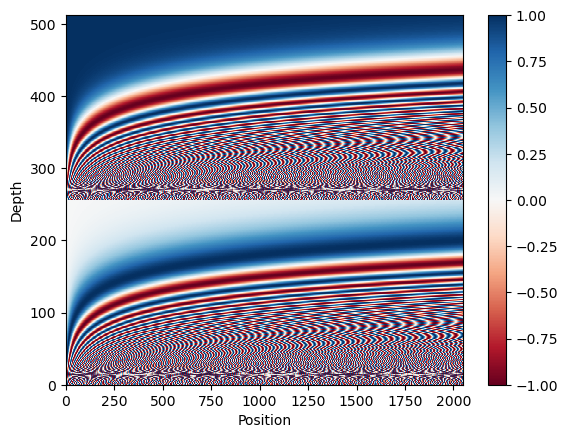

In [5]:
import matplotlib.pyplot as plt
import numpy as np

n, d = 2048, 512

pos_encoding = PositionalEncoding(n, d).pos_encoding
print(pos_encoding.shape)

# Reordena las dimensiones para el plot
pos_encoding = tf.reshape(pos_encoding, (n,d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d,n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()


## <span style="color:#4361EE">Enmascaramiento</span>

### <span style="color:#4CC9F0">Enmascaramiento de los tokens de relleno (padding)</span>

Se enmascaran todos los tokens de padding (relleno) en el lote de secuencia, para asegurar que el modelo no trate el relleno como entrada. Un valor de  0  en la máscara indica que esa posición en la secuencia no es relleno. Un valor de 1 en la máscara indica que esa posición en la secuencia es relleno.

In [6]:
class PaddingMask(tf.keras.layers.Layer):
    def __init__(self, seq):
        super(PaddingMask, self).__init__()
        self.mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # adiciona dimensiones extra para adicionar el relleno
        # a los logits de atención
        self.mask = self.mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
    
    def call():
        return self.mask

In [7]:
# test de la clase PaddingMask
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
padding_mask= PaddingMask(x).mask
padding_mask

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### <span style="color:#4CC9F0">Enmascaramiento de anticipación para la predicción de palabras</span>

La máscara de anticipación se utiliza para enmascarar los tokens futuros en una secuencia. En otras palabras, la máscara indica que las entradas no deben usarse para hacer la predicción de la siguiente palabra predicha.

Esto significa que para predecir la tercera palabra, solo se utilizarán la primera y la segunda palabra. De manera similar, para predecir la cuarta palabra, solo se usarán la primera, la segunda y la tercera palabra y así sucesivamente.

In [8]:
class LookAheadMask(tf.keras.layers.Layer):
    def __init__(self, size):
        super(LookAheadMask, self).__init__()
        self.mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
        
    def call():
        return self.mask

In [9]:
# test de la clase LookAheadMask
x = tf.random.uniform((1, 3))
temp = LookAheadMask(x.shape[1]).mask
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## <span style="color:#4361EE">Auto-atención de producto punto escalado</span>

<figure>
<center>
<img src="../Imagenes/scaled_attention.png" width="400" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Atención de producto escalado</p>
</figcaption>
</figure>

Fuente: [Tensorflow transformer](https://www.tensorflow.org/text/tutorials/transformer)

Suponemos las tres entradas Q(query o consulta), K(key o clave) y V(value o valor). La ecuación para calcular los pesos de atención es

$$
\large \text{Attention}(Q,K,V) = softmax\left( \frac{QK^T}{\sqrt{d_k}}  \right) V
$$

en donde  $d_k$ es el tamaño de entrada de la cabeza. En el transformer original el tamaño del embedding es 512 que se divide en 8 cabezas de tamaño $d_k=64$. Para que los tokens de relleno, usados para tener secuencias de igual tamaño, no tengan pesos de atención se les asigna un valor que tiene a $-\infty$, de tal manera que softmax les asigne el valor cero.

In [10]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    '''Calcula los pesos de atención
    - q, k y v deben tener dimensiones conformables
      para las operaciones indicadas
    - k y v deben coindidir en la penúltima dimensión,
     es decir, seq_len_k seq_len_v
    - mask: puede tener diferentes formas dependiendo si es para
      padding o look ahead. 
         
    Args:
      q: forma de query == (..., seq_len_q, depth)
      k: forma de key == (..., seq_len_k, depth)
      v: forma de value == (..., seq_len_v, depth_v)
      mask: tensor float con forma ajustable
         a (..., seq_len_q, seq_len_k). Por defecto es None.
      
    Returns:
      output, attention_weights
    '''
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def call(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)

        # escala matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
        # adiciona el enmascaramiento al vector escalado
        if mask is not None:
            scaled_attention_logits += mask * -1e9
        
        # softmax se calcula por el último eje(filas) (seq_len_k)
        # es decir, por filas la suma es 1
        attention_weigths = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)
        output = tf.matmul(attention_weigths, v)
   
        return output, attention_weigths # retorna los pesos de atención para análisis de atención solamente
          

### <span style="color:#4CC9F0">Test de la clase ScaledDotProductAttention</span>

In [11]:
def print_out(q, k, v):
    dot_product = ScaledDotProductAttention()
    temp_out, temp_attn = dot_product(q, k, v, None)
    print('Pesos de atención:\n',temp_attn)
    print('Output es:\n', temp_out)

In [12]:
import numpy as np
np.set_printoptions(suppress=True)# suprime notación científica 


temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

In [13]:
# Este 'query' alinea con la segunda 'key',
# por lo que se retorna el segundo valor

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) #(1, 3)
print_out(temp_q, temp_k, temp_v)

Pesos de atención:
 tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output es:
 tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [14]:
# Este query alinea dos valores en key (tercero y cuarto),
# asi que todos los valores son promediados
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Pesos de atención:
 tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output es:
 tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [15]:
# Este query alinea igualmente con las claves primera y segunda igualmente,
# así que los correspondientes valores son promediados
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Pesos de atención:
 tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output es:
 tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Colocando todas las consultas juntas se tiene:

In [16]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Pesos de atención:
 tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output es:
 tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## <span style="color:#4361EE">Capa de atención multi-cabeza</span>

<figure>
<center>
<img src="../Imagenes/multi_head_attention.png" width="400" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Atención multi-cabeza</p>
</figcaption>
</figure>

Fuente: [Tensorflow transformer](https://www.tensorflow.org/text/tutorials/transformer)

Implementamos esta capa utilizando *Model subclassing*. Atención multi-cabeza tiene cuatro partes:

* Capas lineales y separación en cabezas.
* Auto-atención de producto punto escalado.
* Concatenación de las cabezas a la salida.
* Capa lineal final.

Cada bloque de atención multi-cabeza recibe como única entrada un diccionario cuyas claves son *query*, *key* y *value*. Esto se hace así porque con la API funcional de Keras se debe mantener un único parámetro. El diccionario es entonces un envoltorio (*wrapper*) para *query*, *key* y *value*.

La entrada es pasada a través de las capas densas y dividida luego en múltiples cabezas. Entonces cada cabeza aplica la auto-atención del producto punto escalado a la entrada. Una máscara apropiada es usada para enmascarar los tokens de relleno de la secuencia de entrada.

Finalmente las salidads de la auto-atención de producto punto escalado son concatenadas y el resultado se pasa por una capa lineal final.

**Nota:**
La razón de utilizar múltiples cabezas de atención es para permitir que cada cabeza se enfoque en un subconjunto del espacio de incrustación (embedding) de los tokens. 

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
        self.scaled_product_attention = ScaledDotProductAttention()
    
    def split_heads(self, x, batch_size):
        '''Separa la última dimensión (columnas) en (num_heads, depth)
           Transpone el resultado de tal forma que la forma resultante es
           (batch_size, num_heads, seq_len, depth)
        '''
        
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # capas lineales
        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        # separación de cabezas
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
        
        # atención de producto punto escalado
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = self.scaled_product_attention(q, k, v, mask)
        # traspone scaled_attention: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
        
        # concatenación de las salida de las cabezas de atención
        # concat_attention.shape = (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model))
        
        # capa densa final
        output = self.dense(concat_attention) # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

### <span style="color:#4CC9F0">Test de la clase MultiHeadAttention</span>

In [18]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512)) # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(v=y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## <span style="color:#4361EE">Capa Feed Forward</span> 

Esta es la capa densa en el borde superior del Transformer, luego de la atención multicabeza y de la capa residual. Consta de dos capas completamente conectadas con una activación *ReLU* en el medio.

In [19]:
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) # (batch_size, seq_len, d_model)
        ])
        
    def call(self, x):
        return self.ffn(x)

### <span style="color:#4CC9F0">Test de la clase FeedForward</span>

In [20]:
sample_ffn = FeedForwardNetwork(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## <span style="color:#4361EE">Capas de codificación y decodificación</span> 

El modelo Transformer sigue el mismo patrón general como un estándar **seq2seq** con atención. La sentencia  de entrada se pasa a través $N$ capas de codificación (codificadoras) que generan una salida para cada palabra/símbolo en la secuencia.

El decodificador presta atención a la salida del codificador y a su propia entrada (atención propia) para **predecir la siguiente palabra**.

<figure>
<center>
<img src="../Imagenes/Transformer_original.png" width="400" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Transformer</p>
</figcaption>
</figure>

Fuente: [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf)

## <span style="color:#4361EE">Capa codificadora</span> 

La capa codificadora corresponde al rectángulo gris del encoder en la arquitectura del transformer arriba. Cada capa codificadora consta de subcapas:

1. Atención multicabezal (con enmascaramiento de los tokens de padding).
2. Redes densas hacia adelante (feed forward) (pointwise feed fordward).

Cada una de estas subcapas tiene una conexión residual a su alrededor seguida de una normalización de capa. Las conexiones residuales ayudan a evitar el problema del desvanecimiento del gradiente en las redes profundas.

La salida de cada subcapa es `LayerNorm(x + Sublayer(x))` . La normalización se realiza en el `d_model` eje (última). Hay $N$ capas de codificador en el transformer.

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, dff)
        
        # normaliza por el último eje cada ejemplo
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
                
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
          
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

### <span style="color:#4CC9F0">Test de la capa (clase) codificadora</span>

In [22]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
        tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

## <span style="color:#4361EE">Capa decodificadora</span> 

La capa decodificadora corresponde al rectángulo gris del decoder en la arquitectura del transformer arriba. Cada capa decodificadora consta de subcapas:

1. Atención multi-cabeza enmascarada (con máscara de anticipación y máscara de relleno).
2. Atención multi-cabeza (con enmascaramiento de relleno). *V* (valor) y *K* (clave) reciben la salida del codificador como entradas. *Q* (consulta) recibe la salida de la subcapa  multi-cabeza enmascarada.
3. Redes densas hacia adelante (*feed forward*).

Cada una de estas subcapas tiene una conexión residual a su alrededor seguida de una normalización de capa. La salida de cada subcapa es `LayerNorm(x + Sublayer(x))` . La normalización se realiza en el `d_model` eje (última).

Hay $N$ capas decodificadoras en el transformer.

Cuando *Q* recibe la salida del primer bloque de atención del decodificador y *K* recibe la salida del codificador, las ponderaciones de atención representan la importancia dada a la entrada del decodificador en función de la salida del codificador. En otras palabras, el decodificador predice la siguiente palabra mirando la salida del codificador y atendiendo su propia salida. Vea la demostración ejemplo en la sección de atención del producto escalado.

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = FeedForwardNetwork(d_model, dff)
        
        # normaliza por el último eje cada ejemplo
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        # attn1.shape == (batch_size, target_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) 
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        #  attn2.shape == (batch_size, target_seq_len, d_model)
        attn2, attn_weigths_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_out = self.ffn(out2) # (batch_size, target_seq_len, d_model)
        ffn_out = self.dropout3(ffn_out, training=training)
        out3 = self.layernorm3(ffn_out + out2) # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weigths_block2
        

### <span style="color:#4CC9F0">Test de la capa (clase) decodificadora</span>

In [24]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## <span style="color:#4361EE">Codificador</span> 

El Encoder consta de:

1. Incrustación de entrada.
2. Codificación posicional.
3. $N$ capas de codificador.

La entrada se somete a una incrustación (embedding) que se suma con la codificación posicional. La salida de esta suma es la entrada a las capas del codificador. La salida del codificador es la entrada al decodificador.


In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, 
                                                d_model).pos_encoding
        
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, 
                                        rate)  for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # suma embedding y position encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        # dropout
        x = self.dropout(x, training=training)
        
        # pasa por las num_layers capas codificadoras
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x # batch_size, input_seq_len, d_model)
    
    

### <span style="color:#4CC9F0">Test del encoder</span>

In [26]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## <span style="color:#4361EE">Decodificador</span> 

El Decoder consiste en:

1. Incrustación de salida.
2. Codificación posicional.
3. $N$ capas de decodificador.

El objetivo se somete a una incrustación (embedding) que se suma con la codificación posicional. La salida de esta suma es la entrada a las capas del decodificador. La salida del decodificador es la entrada a la capa lineal final.

In [27]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding,
                                               d_model).pos_encoding
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x) # # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    

### <span style="color:#4CC9F0">Test del decoder</span>

In [28]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## <span style="color:#4361EE">Transformer Auto Encoder</span> 

El transformer consta del codificador, el decodificador y una capa lineal final. La salida del decodificador es la entrada a la capa lineal y se devuelve su salida.

In [29]:
class TransformerAutoEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(TransformerAutoEncoder, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              input_vocab_size, pe_input, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                              target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask,
            look_ahead_mask, dec_padding_mask):
        
        # enc_output.shape == (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # final_ouput.shape == (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

### <span style="color:#4CC9F0">Test clase TransformerAutoEncoder</span>

In [30]:
sample_transformer = TransformerAutoEncoder(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## <span style="color:#4361EE">Hiperparámetros</span> 

Los valores usados  en el modelo base de Transformer, en  [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf) fueron; `num_layers = 6`, `d_model = 512`, `dff = 2,048`. 

Por ejemplo podemos definir:

In [31]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## <span style="color:#4361EE">Optimizador</span> 

En el artículo original [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf) se usó el optimzador [Adam](https://arxiv.org/pdf/1412.6980.pdf) con un programador (*scheduler*) de velocidad de aprendizaje personalizado de acuerdo a la fórmula:

$$
lrate = d^{-0.5}_{\text{model}} \cdot \min(\text{step_num}^{-0.5}, \text{step_num}\cdot \text{warmup_steps}^{-1.5})
$$

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

In [33]:
# instancia un optimizador con esta rata de aprendizaje programada
d_model = 128 # es solo un ejemplo

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)

### <span style="color:#4CC9F0">Test (plot) de la clase CustomSchedule</span>

Text(0.5, 0, 'Paso de entrenamiento')

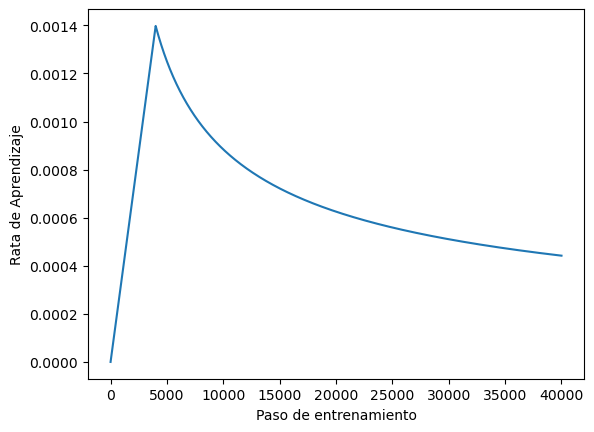

In [34]:
d_model = 128
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Rata de Aprendizaje")
plt.xlabel("Paso de entrenamiento")

## <span style="color:#4361EE">Transformer</span> 

In [35]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        # objeto autoencoder transformer
        self.transformer = TransformerAutoEncoder(num_layers, d_model, 
                            num_heads, dff, input_vocab_size,
                            target_vocab_size, pe_input, pe_target, rate=0.1)
        
        # Programación de rata de aprendizaje
        self.learning_rate = CustomSchedule(d_model)
        
        # optimizador: Adam
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, beta_1=0.9, 
                                                beta_2=0.98, epsilon=1e-9)
        
        # objeto loss: SparseCategoricalCrossentropy
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                            from_logits=True, reduction='none')
        
        # convierte la función train_step a una Function de tf para optimizar ejecución
        self.train_step_signature = [
            tf.TensorSpec(shape =(None, None), dtype=tf.int64),
            tf.TensorSpec(shape =(None, None), dtype=tf.int64),
        ]
        self.train_step = tf.function(func=self.train_step, 
                                      input_signature=self.train_step_signature)
            
        # objectos métricas
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
        
        # check points
        self.checkpoint_path = './checkpoints/train'
        
        self.ckpt = tf.train.Checkpoint(transformer = self.transformer,
                                       optimizer = self.optimizer) # model = self.transformer??
        
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.checkpoint_path, max_to_keep=5)
        
        # si existe checkpoint restaura el último checkpoint
        if self.ckpt_manager.latest_checkpoint:
            self.ckpt.restore(ckpt_manager.latest_checkpoint)
            print('Ultimo checkpoint restaurado!!')
    
    
    # función paso de entrenamiento. Se convierte en Function con tf.function en __init__()
    def train_step(inp, tar):
        tar_inp  = tar[:, :-1]
        tar_real = tar[:, 1:]
        
        enc_padding_mask, combined_mask, dec_padding_mask = self.create_mask(inp, tar_inp)
        
        with tf.Gradient() as tape:
            predictions, _ = self.transformer(inp, tar_inp,
                                             True, 
                                             enc_padding_mask,
                                             combined_mask,
                                             dec_padding_mask)
            loss = self.loss_function(tar_real, predictions)
        
        gradients = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.transformer.trainable_variables))
        
        self.train_loss(loss)
        self.train.accuracy(self.accuracy_function(tar_real, predictions))
   
    
    #función de entrenamiento: fit
    def fit(train_batches, epochs=1):
        for epoch in range(epochs):
            start = time.time()
            
            self.train_loss.reset_states()
            self.accuracy.reset_states()
            
            for (batch, (inp, tar)) in enumerate(train_batches):
                self.train_step(inp, tar)
                
                if batch % 50 == 0:
                    print(f'Epoch {epoch + 1} Batch {batch} Loss {self.train_loss.result():.4f} Accuracy {self.train_accuracy.result():.4f}')
                
            if (epoch+1) % 5 == 0:
                self.ckpt_save_path = self.ckpt_manager.save()
                print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

            print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
                
    
    # Función de pérdida
    def loss_function(real, pred):
        '''solamente usa funciones de tensorflow para optimizar ejecución'''
        # enmascara la pérdida para no considerar los términos de padding
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        
        return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
        
    
    # Métricas de evaluación
    def accuracy_function(real, pred):
        # pred.shape == (batch_size, tar_seq_len, target_vocab_size)
        accuracies = tf.equal(real, tf.argmax(pred, axis=2))
        
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        accuracies = tf.math.logical_and(mask, accuracies)
        
        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)
    
    
    
    # creación de enmascaramientos
    def create_mask(inp, tar):
        # Encoder padding mask
        enc_padding_mask = PaddingMask(inp).mask
        
        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = PaddingMask(inp).mask
            
        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = LookAheadMask(tf.shape(tar)[1]).mask
        dec_target_padding_mask = PaddingMask(tar).mask
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
        return enc_padding_mask, combined_mask, dec_padding_mask
    
    

## <span style="color:#4361EE">Referencias</span> 

1. [Tutorial Transformer de Google](https://www.tensorflow.org/text/tutorials/transformer)
1. [Transformer-chatbot-tutorial-with-tensorflow-2](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html)
1. [Transformer Architecture: The positional encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
1. [Illustrated Auto-attención](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)
1. [Illustrated Attention](https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3#0458)
1. [Neural Machine Translation by Jointly Learning to Align and Translate (Bahdanau et. al, 2015)](https://arxiv.org/pdf/1409.0473.pdf)
1. [Effective Approaches to Attention-based Neural Machine Translation (Luong et. al, 2015)](https://arxiv.org/pdf/1508.04025.pdf)
1. [Attention Is All You Need (Vaswani et. al, 2017)](https://arxiv.org/pdf/1706.03762.pdf)
1. [Self-Attention GAN (Zhang et. al, 2018)](https://arxiv.org/pdf/1805.08318.pdf)
1. [Sequence to Sequence Learning with Neural Networks (Sutskever et. al, 2014)](https://arxiv.org/pdf/1409.3215.pdf)
1. [TensorFlow’s seq2seq Tutorial with Attention (Tutorial on seq2seq+attention)](https://github.com/tensorflow/nmt)
1. [Lilian Weng’s Blog on Attention (Great start to attention)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#a-family-of-attention-mechanisms)
1. [Jay Alammar’s Blog on Seq2Seq with Attention (Great illustrations and worked example on seq2seq+attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
1. [Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (Wu et. al, 2016)](https://arxiv.org/pdf/1609.08144.pdf)
1. [Adam: A method for stochastic optimization](https://arxiv.org/pdf/1412.6980.pdf)